In [1]:
import os
import numpy as np
import pandas as pd
import functools
import torch
from environment import ForexEnv
from agents import DQNAgent
from agents import Forex_reward_function
from feature import ForexIdentityFeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

cpu
cpu


In [19]:
loss = []
eps1 = []
loss_file = open('./AUDUSD/log/loss.txt','r')
count = 1
for line in loss_file:
    loss.append(float(line.split(" ")[-1][:-1]))
    eps1.append(10*count)
    count += 1

In [20]:
train_reward = []
eps2 = []
train_reward_file = open('./AUDUSD/log/train_reward.txt','r')
count = 1
for line in train_reward_file:
    train_reward.append(float(line.split(" ")[-2][7:-1]))
    eps2.append(100*count)
    count += 1

In [21]:
eval_reward = []
eps3 = []
eval_reward_file = open('./AUDUSD/log/eval_reward.txt','r')
count = 1
for line in eval_reward_file:
    eval_reward.append(float(line.split(" ")[-2][7:-1]))
    eps3.append(200*count)
    count += 1

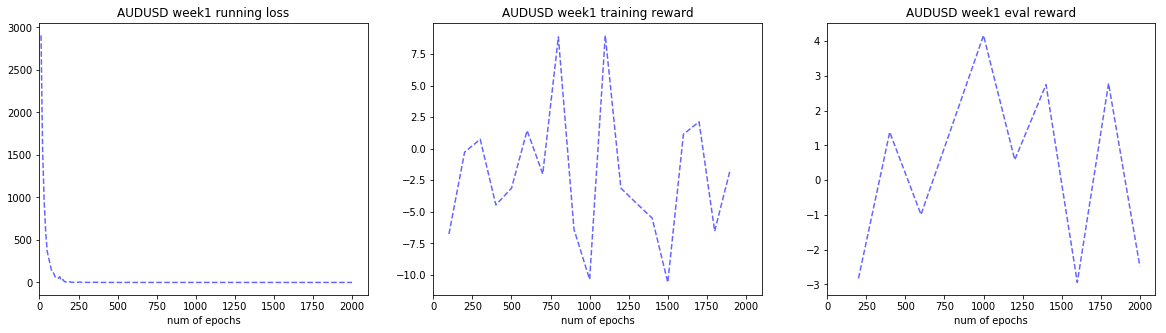

In [26]:
title = ['AUDUSD week1 running loss', 'AUDUSD week1 training reward', 'AUDUSD week1 eval reward']
eps = [eps1, eps2, eps3]
rewards = [loss, train_reward, eval_reward]
plt.rcParams['figure.figsize'] = [20, 5]
fig = plt.figure()
gs = gridspec.GridSpec(1, 3)
for n in range(3):
    ax = fig.add_subplot(gs[0, n]) 
    ax.plot(eps[n], rewards[n], 'b--',alpha = 0.6)
    ax.set(xlabel='num of epochs', ylabel='')
    ax.set_title(title[n])
    ax.set_xlim(0, 2100)

In [6]:
HOURLY_RF_RATE = 2.68 * 10 / 365.0 / 24.0

num_episodes = 50
env = ForexEnv(mode = 'eval')
max_timesteps = 3600
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
device = torch.device("cpu")

agent = DQNAgent(
        action_set=[0, 1, 2],
        reward_function=functools.partial(Forex_reward_function),
        feature_extractor=ForexIdentityFeature(),
        hidden_dims=[50,50],
        test_model_path='AUDUSD/agents/20190601-210619/dqn|0.pt')

def get_reward(index_history, price_record_history, action_history):
    accumulative_reward = 0
    assert (len(action_history) == len(index_history)-1)
    assert (len(price_record_history) == len(index_history))
    timespan = len(action_history)
    for t in range(timespan):
        if t == 0:
            prev_position = 0
        else:
            prev_position = action_history[t - 1] -1
        if t == len(action_history) - 1:
            position = 0
        else:
            position = action_history[t] -1
        bid, ask, next_bid, next_ask = price_record_history[t]
        
        action = position - prev_position
        price = 0
        
        if action > 0:
            price = next_ask
        elif action < 0:
            price = next_bid
        reward = torch.sum(torch.tensor(-1.).float() * action * price).to(device)
        accumulative_reward += reward
    return index_history[0], accumulative_reward 

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location='cpu' to map your storages to the CPU.

In [21]:
_eps = []
_idxs = []
rewards = []
# g_mat = np.zeros((num_episodes, 296))

for episode in range(num_episodes):
    agent.reset_cumulative_reward()
    new_env = env.reset_fixed(episode * 3600)
    observation_history = [(new_env[0], new_env[1], new_env[2], False)]
    price_record_history =[new_env[2]]
    index_history = [new_env[0]]
    action_history = []

    t = 0
    done = False
#     sensitivity = [0] * 296
    while not done:
        action = agent.act(observation_history, action_history)
        timestamp, state, price_record, done = env.step(action)
        index_history.append(timestamp)
        price_record_history.append(price_record)
        action_history.append(action)
        observation_history.append((timestamp, state, price_record, done))
        t += 1
        done = done or (t == max_timesteps)
        
#         obs = observation_history[-1][1].data.numpy()
#         for i in range(len(obs)):
#             obs[i] += 0.00001
#             tmp_1, _, tmp_3, tmp_4 = observation_history[-1]
#             observation_history[-1] = (tmp_1, torch.tensor(obs).to(device), tmp_3, tmp_4)
#             sens_action = agent.act(observation_history, action_history)
#             if action != sens_action:
#                 sensitivity[i] += 1
#             obs[i] -= 0.00001
#             observation_history[-1] = (tmp_1, torch.tensor(obs).to(device), tmp_3, tmp_4)
            
#     sensitivity = [elem/3600.0 for elem in sensitivity]
#     g_mat[episode] = np.array(sensitivity)
        
    _id , reward = get_reward(index_history, price_record_history, action_history)
    _eps.append(episode)
    _idxs.append(_id)
    rewards.append(reward)
    print("Testing on the {} datapoint drawing from {} th data and return is {}".format(episode,_id,reward))
    print("{} short positions".format(action_history.count(0)))
    print("{} neutral positions".format(action_history.count(1)))
    print("{} long positions".format(action_history.count(2)))

print("Testing on the {} datapoint and average return is {}".format(num_episodes,np.mean(np.asarray(rewards))))
output = pd.DataFrame({'num_episode': _eps, 'data_idx': _idxs, 'reward': rewards})
output.to_csv('AUDUSD/results/20190601-142238/test_rewards.csv', index = False)

_mean = np.mean(np.asarray(rewards))
_std = np.std(np.asarray(rewards))
sharpe_ratio = (_mean - HOURLY_RF_RATE) / _std
print("Mean {}, std {} and Sharpe ratio {}".format(_mean, _std, sharpe_ratio))

# g_avg = np.mean(g_mat, axis=0)
# np.save('all_sensitivity.npy', g_mat)

Testing on the 0 datapoint drawing from 0 th data and return is -0.8399658203125
0 short positions
0 neutral positions
3600 long positions
Testing on the 1 datapoint drawing from 3600 th data and return is -0.56024169921875
0 short positions
35 neutral positions
3565 long positions
Testing on the 2 datapoint drawing from 7200 th data and return is -1.7210693359375
0 short positions
131 neutral positions
3469 long positions
Testing on the 3 datapoint drawing from 10800 th data and return is -10.76068115234375
0 short positions
855 neutral positions
2745 long positions
Testing on the 4 datapoint drawing from 14400 th data and return is -16.65960693359375
0 short positions
1732 neutral positions
1868 long positions
Testing on the 5 datapoint drawing from 18000 th data and return is -16.34796142578125
0 short positions
2254 neutral positions
1346 long positions
Testing on the 6 datapoint drawing from 21600 th data and return is -15.831298828125
0 short positions
2378 neutral positions
1222

KeyboardInterrupt: 

In [22]:
df = pd.read_csv('./data/eval_AUDUSD_lag_32_week1.csv')
df.iloc[:,9:]

,ask pad,bid_lag_1,ask_lag_1,bid_lag_2,ask_lag_2,bid_lag_3,ask_lag_3,bid_lag_4,ask_lag_4,bid_lag_5,...,USDSEK_lag_27,USDSEK_lag_28,USDSEK_lag_29,USDSEK_lag_30,USDSEK_lag_31,USDSEK_lag_32,time_1,time_2,time_3,time_4
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000028,...,0.000005,0.000005,0.000005,0.000005,0.000005,-0.000007,0.974928,0.000000,0.000000,0.707107
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.974928,0.000000,0.000000,0.669131
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022,0.974928,0.000000,0.000000,0.629320
3,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022,0.974928,0.000000,0.000000,0.587785
4,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022,0.974928,0.000000,0.000000,0.544639
5,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022,0.974928,0.000000,0.000000,0.500000
6,0.0,0.000000,0.000014,0.000000,0.000014,0.000000,0.000014,0.000000,0.000014,0.000000,...,0.000004,-0.000022,-0.000022,-0.000022,-0.000022,-0.000022,0.974928,0.000000,0.000000,0.453990
7,1.0,0.000000,0.000000,0.000000,0.000014,0.000000,0.000014,0.000000,0.000014,0.000000,...,0.000004,0.000004,-0.000022,-0.000022,-0.000022,-0.000022,0.974928,0.000000,0.000000,0.406737
8,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000014,0.000000,0.000014,0.000000,...,0.000004,0.000004,0.000004,-0.000022,-0.000022,-0.000022,0.974928,0.000000,0.000000,0.358368
9,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000014,0.000000,...,0.000004,0.000004,0.000004,0.000004,-0.000022,-0.000022,0.974928,0.000000,0.000000,0.309017
